# ML CUP 2022

## Support Vector Machine

This notebook creates two Support Vector Machine (SVM) models to generalize the problem of the ML cup 2022. It searches the best combination of hyperparameters performing a grid searches over a given range of values. Two different models are given as output in this phase, one for each target, and for both models there is a tuning phase based on the same hyperparameters. In the end of the notebook there is a comparison between the learning curves of KRR and SVR models.

Hyperparameters considered for the grid search:

1. kernel
2. C
3. epsilon
4. gamma (only for rbf and poly kernels)
5. degree (only for poly kernel)

Model selection performed using a cross validation.\
The model assessment phase is not included in this notebook.

### Importing libraries

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA

from sklearn.metrics import make_scorer
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

import joblib

### Definition of the Mean Euclidean Distance

In [55]:
def my_mean_euclidean_distance(y_true, y_pred):
    points = len(y_true)
    tot_sum = 0
    for i in range (points):
        tot_sum += LA.norm(y_true[i] - y_pred[i])
    
    return tot_sum / points

In [56]:
mean_euclidean_distance = make_scorer(my_mean_euclidean_distance, greater_is_better=False)

### Loading data

In [57]:
colnames = ['id', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'target1', 'target2']
mlcup_tr = pd.read_csv("./dataset/ml_cup22/ML-CUP22-TR.csv", sep = ",", names=colnames)
mlcup_tr = mlcup_tr.iloc[1:, :]
mlcup_tr = mlcup_tr.drop('id', axis=1)

In [58]:
x_mlcup_tr = mlcup_tr.iloc[:, 0:9].values
y_mlcup_tr = mlcup_tr.iloc[:, 9:11].values

We used the function below to normalize our training set (both input and target) according to a min-max normalization

In [59]:
x_cols = len(x_mlcup_tr[0])

max_col_value_x = [None]*x_cols
max_vl = None

min_col_value_x = [None]*x_cols
min_vl = None

for i in range(x_cols):
    col = x_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    x_mlcup_tr[:, i] = (x_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_x[i] = max_vl
    min_col_value_x[i] = min_vl
    
    
    
y_cols = len(y_mlcup_tr[0])

max_col_value_y = [None]*y_cols

min_col_value_y = [None]*y_cols

for i in range(y_cols):
    col = y_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    y_mlcup_tr[:, i] = (y_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_y[i] = max_vl
    min_col_value_y[i] = min_vl 

In [60]:
y1_mlcup_tr = y_mlcup_tr[:, 0]
y2_mlcup_tr = y_mlcup_tr[:, 1]

### Grid search for target 1
#### rbf kernel

In [61]:
C_range = np.logspace(-2, 5, 30, base = 2)
gamma_range = np.logspace(-9, 3, 10, base = 2)
epsilon_range = np.arange(0.1, 0.5, 0.1)

param_grid = dict(
    gamma = gamma_range,
    C = C_range,
    epsilon = epsilon_range
)

grid = GridSearchCV(
    SVR(kernel = 'rbf'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4,
    n_jobs = -1
)

grid.fit(x_mlcup_tr, y1_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 4 folds for each of 1200 candidates, totalling 4800 fits
The best parameters are {'C': 0.295530576797567, 'epsilon': 0.1, 'gamma': 1.259921049894872} with a score of -0.04


In [62]:
rbf_classifier_1 = grid.best_estimator_

rbf_results_1 = rbf_classifier_1.fit(x_mlcup_tr, y1_mlcup_tr)

### linear kernel

In [63]:
C_range = np.logspace(-2, 10, 100, base = 2)
epsilon_range = np.arange(0.1, 0.5, 0.1)

param_grid = dict(
    C = C_range,
    epsilon = epsilon_range
)

grid = GridSearchCV(
    SVR(kernel = 'linear'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4,
    n_jobs = -1 
)

grid.fit(x_mlcup_tr, y1_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 4 folds for each of 400 candidates, totalling 1600 fits
The best parameters are {'C': 136.3252594483153, 'epsilon': 0.1} with a score of -0.05


In [64]:
linear_classifier_1 = grid.best_estimator_
linear_results_1 = linear_classifier_1.fit(x_mlcup_tr, y1_mlcup_tr)

### polynomial kernel

In [65]:
degree_range = np.arange(2, 5, 1)
C_range = np.logspace(-9, 5, 10, base = 2)
gamma_range = np.logspace(-9, 1, 10, base = 2)
epsilon_range = np.arange(0.1, 0.5, 0.1)

param_grid = dict(
    degree = degree_range,
    C = C_range,
    gamma = gamma_range,
    epsilon = epsilon_range
)

grid = GridSearchCV(
    SVR(kernel = 'poly'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4,
    n_jobs = -1
)

grid.fit(x_mlcup_tr, y1_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 4 folds for each of 1200 candidates, totalling 4800 fits
The best parameters are {'C': 3.7034988491491627, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.9258747122872907} with a score of -0.05


In [66]:
poly_classifier_1 = grid.best_estimator_
poly_results_1 = poly_classifier_1.fit(x_mlcup_tr, y1_mlcup_tr)

### Grid search for target 2
#### rbf kernel

In [67]:
C_range = np.logspace(-2, 5, 30, base = 2)
gamma_range = np.logspace(-9, 3, 30, base = 2)
epsilon_range = np.arange(0.1, 0.5, 0.1)

param_grid = dict(
    gamma = gamma_range,
    C = C_range,
    epsilon = epsilon_range
)

grid = GridSearchCV(
    SVR(kernel = 'rbf'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4,
    n_jobs = -1
)

grid.fit(x_mlcup_tr, y2_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 4 folds for each of 3600 candidates, totalling 14400 fits
The best parameters are {'C': 0.25, 'epsilon': 0.1, 'gamma': 2.5399983964682855} with a score of -0.07


In [68]:
rbf_classifier_2 = grid.best_estimator_
rbf_results_2 = rbf_classifier_2.fit(x_mlcup_tr, y2_mlcup_tr)

#### linear kernel

In [69]:
C_range = np.logspace(-2, 10, 100, base = 2)
epsilon_range = np.arange(0.1, 0.5, 0.1)

param_grid = dict(
    C = C_range,
    epsilon = epsilon_range
)

grid = GridSearchCV(
    SVR(kernel = 'linear'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4,
    n_jobs = -1
)

grid.fit(x_mlcup_tr, y2_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 4 folds for each of 400 candidates, totalling 1600 fits
The best parameters are {'C': 0.25, 'epsilon': 0.1} with a score of -0.08


In [70]:
linear_classifier_2 = grid.best_estimator_
linear_results_2 = linear_classifier_2.fit(x_mlcup_tr, y2_mlcup_tr)

#### polynomial kernel

In [71]:
degree_range = np.arange(2, 5, 1)
C_range = np.logspace(-9, 5, 10, base = 2)
gamma_range = np.logspace(-9, 1, 10, base = 2)
epsilon_range = np.arange(0.1, 0.5, 0.1)

param_grid = dict(
    degree = degree_range,
    C = C_range,
    gamma = gamma_range,
    epsilon = epsilon_range
)

grid = GridSearchCV(
    SVR(kernel = 'poly'),
    param_grid = param_grid,
    cv = 4,
    scoring = mean_euclidean_distance,
    verbose = 4,
    n_jobs = -1
)

grid.fit(x_mlcup_tr, y2_mlcup_tr)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

Fitting 4 folds for each of 1200 candidates, totalling 4800 fits
The best parameters are {'C': 3.7034988491491627, 'degree': 2, 'epsilon': 0.1, 'gamma': 0.4286219914265367} with a score of -0.08


In [72]:
poly_classifier_2 = grid.best_estimator_
poly_results_2 = poly_classifier_2.fit(x_mlcup_tr, y2_mlcup_tr)

## Model selection
### Target 1

In [73]:
mee_1 = my_mean_euclidean_distance(y1_mlcup_tr, rbf_classifier_1.predict(x_mlcup_tr))
print("MEE score: %0.5f" %(mee_1))

MEE score: 0.03902


In [74]:
mee_1 = my_mean_euclidean_distance(y1_mlcup_tr, linear_classifier_1.predict(x_mlcup_tr))
print("MEE score: %0.5f" %(mee_1))

MEE score: 0.05287


In [75]:
mee_1 = my_mean_euclidean_distance(y1_mlcup_tr, poly_classifier_1.predict(x_mlcup_tr))
print("MEE score: %0.5f" %(mee_1))

MEE score: 0.05103


### Target 2

In [76]:
mee_2 = my_mean_euclidean_distance(y2_mlcup_tr, rbf_classifier_2.predict(x_mlcup_tr))
print("MEE score: %0.5f" %(mee_2))

MEE score: 0.06402


In [77]:
mee_2 = my_mean_euclidean_distance(y2_mlcup_tr, linear_classifier_2.predict(x_mlcup_tr))
print("MEE score: %0.5f" %(mee_2))

MEE score: 0.08246


In [78]:
mee_2 = my_mean_euclidean_distance(y2_mlcup_tr, poly_classifier_2.predict(x_mlcup_tr))
print("MEE score: %0.5f" %(mee_2))

MEE score: 0.07553


Since the best results are given by the Support Vector Machine classifier with the rbf kernel both on the first and second target, we choose these two models.

In [38]:
joblib.dump(rbf_classifier_1, './results/ml_cup/SVM/rbf_classifier_1.z')
joblib.dump(rbf_classifier_2, './results/ml_cup/SVM/rbf_classifier_2.z')

['./results/ml_cup/SVM/rbf_classifier_2.z']

### Comparison between SVM and KRR

In [79]:
from sklearn.model_selection import learning_curve

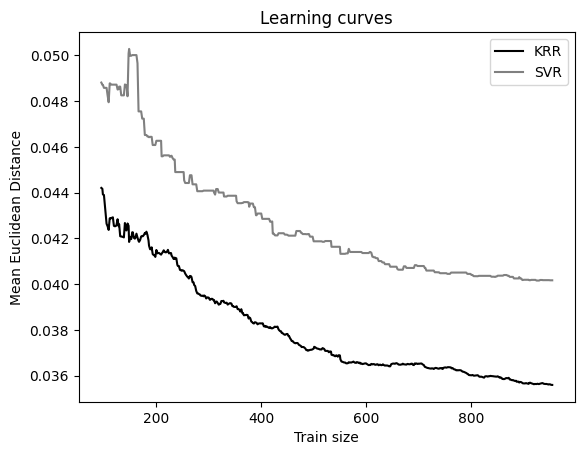

In [81]:
plt.figure()

svr = joblib.load('./results/ml_cup/SVM/rbf_classifier_1.z')
kr = joblib.load('./results/ml_cup/KRR/rbf_krr_1.z')
train_sizes, train_scores_svr, test_scores_svr = learning_curve(
    svr,
    x_mlcup_tr,
    y1_mlcup_tr,
    train_sizes = np.linspace(0.1, 1, 500),
    scoring = mean_euclidean_distance,
    cv = 5,
)
train_sizes_abs, train_scores_kr, test_scores_kr = learning_curve(
    kr,
    x_mlcup_tr,
    y1_mlcup_tr,
    train_sizes = np.linspace(0.1, 1, 500),
    scoring = mean_euclidean_distance,
    cv = 5,
)

plt.plot(train_sizes, -test_scores_kr.mean(1), color="black", label="KRR")
plt.plot(train_sizes, -test_scores_svr.mean(1), color="grey", label="SVR")
plt.xlabel("Train size")
plt.ylabel("Mean Euclidean Distance")
plt.title("Learning curves")
plt.legend(loc="best")

plt.show()

In [ ]:
plt.figure()

svr = joblib.load('./results/ml_cup/SVM/rbf_classifier_2.z')
kr = joblib.load('./results/ml_cup/KRR/rbf_krr_2.z')
train_sizes, train_scores_svr, test_scores_svr = learning_curve(
    svr,
    x_mlcup_tr,
    y2_mlcup_tr,
    train_sizes = np.linspace(0.1, 1, 500),
    scoring = mean_euclidean_distance,
    cv = 5,
)
train_sizes_abs, train_scores_kr, test_scores_kr = learning_curve(
    kr,
    x_mlcup_tr,
    y2_mlcup_tr,
    train_sizes = np.linspace(0.1, 1, 500),
    scoring = mean_euclidean_distance,
    cv = 5,
)

plt.plot(train_sizes, -test_scores_kr.mean(1), color="black", label="KRR")
plt.plot(train_sizes, -test_scores_svr.mean(1), color="grey", label="SVR")
plt.xlabel("Train size")
plt.ylabel("Mean Euclidean Distance")
plt.title("Learning curves")
plt.legend(loc="best")

plt.show()